## The Model

from : https://www.tensorflow.org/probability/examples/Probabilistic_PCA

Probabilistic principal components analysis (PCA) is a
dimensionality reduction technique that
analyzes data via a lower dimensional latent space
([Tipping and Bishop 1999](#1)). It is often
used when there are missing values in the data or for multidimensional
scaling.


Consider a data set $\mathbf{X} = \{\mathbf{x}_n\}$ of $N$ data
points, where each data point is $D$-dimensional, $\mathbf{x}_n \in
\mathbb{R}^D$. We aim to represent each $\mathbf{x}_n$ under a latent
variable $\mathbf{z}_n \in \mathbb{R}^K$ with lower dimension, $K <
D$. The set of principal axes $\mathbf{W}$ relates the latent variables to
the data.

Specifically, we assume that each latent variable is normally distributed,

$$
\begin{equation*}
\mathbf{z}_n \sim N(\mathbf{0}, \mathbf{I}).
\end{equation*}
$$

The corresponding data point is generated via a projection,

$$
\begin{equation*}
\mathbf{x}_n \mid \mathbf{z}_n
\sim N(\mathbf{W}\mathbf{z}_n, \sigma^2\mathbf{I}),
\end{equation*}
$$

where the matrix $\mathbf{W}\in\mathbb{R}^{D\times K}$ are known as
the principal axes. In probabilistic PCA, we are typically interested in
estimating the principal axes $\mathbf{W}$ and the noise term
$\sigma^2$.

Probabilistic PCA generalizes classical PCA. Marginalizing out the the
latent variable, the distribution of each data point is

$$
\begin{equation*}
\mathbf{x}_n \sim N(\mathbf{0}, \mathbf{W}\mathbf{W}^\top + \sigma^2\mathbf{I}).
\end{equation*}
$$

Classical PCA is the specific case of probabilistic PCA when the
covariance of the noise becomes infinitesimally small, $\sigma^2 \to 0$.

We set up our model below. In our analysis, we assume $\sigma$ is known, and
instead of point estimating $\mathbf{W}$ as a model parameter, we
place a prior over it in order to infer a distribution over principal
axes.

# Simulation

In [1]:
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)
from BI import bi,jnp
import matplotlib.pyplot as plt
from jax import vmap
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
m = bi(platform='cpu')



# --- 1. Define and Generate the Hierarchical Data ---
# (This part is correct and remains unchanged)
def sim_data_hierarchical(data_dim, num_datapoints, stddv_datapoints, seed=0):
    latent_dim = 4
    latent_scales = jnp.array([10.0, 5.0, 2.0, 0.5])
    w = m.dist.normal(0, 1, shape=(data_dim, latent_dim), name='w', sample=True, seed=seed)
    z = m.dist.normal(0, 1, shape=(latent_dim, num_datapoints), name='z', sample=True, seed=seed)
    z_scaled = z * latent_scales[:, None]
    x = m.dist.normal(w @ z_scaled, stddv_datapoints, name='x', sample=True, seed=seed)
    return w, z_scaled, x

num_datapoints = 500
data_dim = 4
stddv_datapoints = 0.5
actual_w_h, actual_z_h, x_train_h = sim_data_hierarchical(data_dim, num_datapoints, stddv_datapoints, seed=20)

jax.local_device_count 16


## Model

In [2]:


# Model using simulated data
#def model(x_train, data_dim, latent_dim, num_datapoints): 
#    w = m.dist.normal(0, 1, shape=(data_dim, latent_dim), name='w')
#    z = m.dist.normal(0, 1, shape=(latent_dim, num_datapoints), name='z')
#    epsilon = m.dist.exponential(1, name='epsilon')
#    m.dist.normal(w @ z , epsilon, obs = x_train)  



In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# --- 1. Define and Generate the Hierarchical Data ---
# (This part is correct and remains unchanged)
def sim_data_hierarchical(data_dim, num_datapoints, stddv_datapoints, seed=0):
    latent_dim = 4
    latent_scales = jnp.array([10.0, 5.0, 2.0, 0.5])
    w = m.dist.normal(0, 1, shape=(data_dim, latent_dim), name='w', sample=True, seed=seed)
    z = m.dist.normal(0, 1, shape=(latent_dim, num_datapoints), name='z', sample=True, seed=seed)
    z_scaled = z * latent_scales[:, None]
    x = m.dist.normal(w @ z_scaled, stddv_datapoints, name='x', sample=True, seed=seed)
    return w, z_scaled, x

num_datapoints = 500
data_dim = 4
stddv_datapoints = 0.5
actual_w_h, actual_z_h, x_train_h = sim_data_hierarchical(data_dim, num_datapoints, stddv_datapoints, seed=20)



In [4]:

# --- 2. THE FINAL CORRECTED MODEL DEFINITION ---
def model_final(x_train, data_dim, latent_dim, num_datapoints):
    """
    Probabilistic PCA model with ARD (Automatic Relevance Determination) prior on weights and a correctly defined noise model. ARD helps in automatic relevance determination of latent dimensions, by allowing the model to learn which dimensions are important.
    Args:
        x_train: Observed data matrix of shape (data_dim, num_datapoints).
        data_dim: Dimensionality of the observed data.
        latent_dim: Dimensionality of the latent space.
        num_datapoints: Number of data points.
    """
    # ARD Prior on w (This part is correct)
    alpha = m.dist.gamma(.05, 1e-3, shape=(latent_dim,), name='alpha')
    w = m.dist.normal(0, 1. / jnp.sqrt(alpha)[None, :], shape=(data_dim, latent_dim), name='w')

    # Prior on z (This part is correct)
    z = m.dist.normal(0, 1., shape=(latent_dim, num_datapoints), name='z')

    # --- CORRECTED NOISE MODEL ---
    # Prior on the precision (1 / variance)
    precision = m.dist.gamma(1.0, 1.0, name='precision')
    # The standard deviation is 1 / sqrt(precision)
    stddv = 1. / jnp.sqrt(precision)

    # Use the correctly defined standard deviation in the likelihood
    m.dist.normal(w @ z, stddv, obs=x_train)



sample: 100%|██████████| 1000/1000 [00:35<00:00, 28.24it/s, 255 steps of size 2.09e-02. acc. prob=0.83]
/tmp/ipykernel_80860/3644858733.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


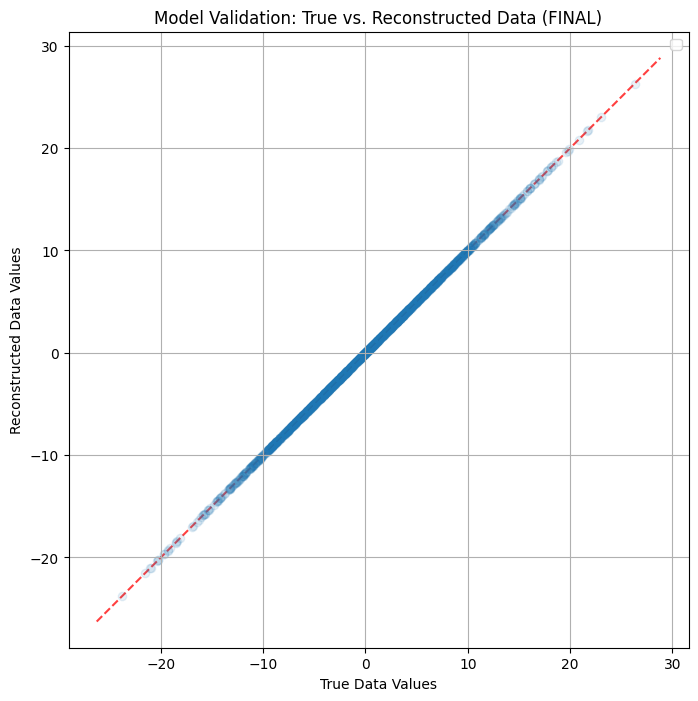

True noise standard deviation: 0.5
Inferred noise standard deviation: 0.0636


In [5]:

# --- 3. Fit the Final Model ---
m.data_on_model = dict(
    x_train=x_train_h,
    data_dim=data_dim,
    latent_dim=4,
    num_datapoints=num_datapoints
)
m.fit(model_final)

# --- 4. Correctly Calculate and Plot the Reconstruction ---
# (This logic was already correct from the previous step)
w_samples = m.posteriors['w']
z_samples = m.posteriors['z']

reconstruct_one_sample = lambda w, z: w @ z
x_reconstructed_samples = jax.vmap(reconstruct_one_sample)(w_samples, z_samples)
x_reconstructed_correct = x_reconstructed_samples.mean(axis=0)

plt.figure(figsize=(8, 8))
plt.scatter(x_train_h.flatten(), x_reconstructed_correct.flatten(), alpha=0.1)
x_lims, y_lims = plt.xlim(), plt.ylim()
all_lims = jnp.array([x_lims, y_lims])
lims = [jnp.min(all_lims), jnp.max(all_lims)]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
plt.xlabel("True Data Values")
plt.ylabel("Reconstructed Data Values")
plt.title("Model Validation: True vs. Reconstructed Data (FINAL)")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

# Optional: Check if the model learned the correct noise level
posterior_stddv = 1. / jnp.sqrt(m.posteriors['precision'].mean())
print(f"True noise standard deviation: {stddv_datapoints}")
print(f"Inferred noise standard deviation: {posterior_stddv:.4f}")

# Estimations are inverted due to **Sign Ambiguity in PCA**: 



Principal Component Analysis (PCA) identifies directions (principal components) that capture the maximum variance in the data. However, the orientation of these components is not unique; both a vector and its negation represent the same principal direction. This means that if 𝑤 is a principal component, −𝑤 is equally valid.

To resolve this issue, we can align the signs of the estimated parameters with the true parameters before comparison. 

Compute the Dot Product: Calculate the dot product between the true parameters and the estimated parameters. This will help determine the relative orientation.

Align Signs: If the dot product is negative, multiply the estimated parameters by -1 to align them with the true parameters.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


true_params = jnp.array(real_data)      
estimated_params = jnp.array(posteriors)

# Compute dot product
dot_product = jnp.dot(true_params, estimated_params)

# Align signs if necessary
if dot_product < 0:
    estimated_params = -estimated_params

# Plot the aligned parameters
plt.scatter(true_params, estimated_params, alpha=0.7)
plt.plot([min(true_params), max(true_params)], [min(true_params), max(true_params)], 'r--')
plt.xlabel('True Parameters')
plt.ylabel('Estimated Parameters')
plt.title('True vs. Estimated Parameters After Sign Alignment')
plt.show()

# Sklearn comparison

In [8]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
import numpy as np # For plotting compatibility
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)
from BI import bi,jnp
import matplotlib.pyplot as plt

m = bi(platform='cpu')

# --- JAX Setup ---
key = jax.random.PRNGKey(42)

# --- Load and Scale Data (from scratch with JAX) ---
iris = load_iris()
X_raw = jnp.array(iris.data)
y = jnp.array(iris.target)
feature_names = iris.feature_names
target_names = iris.target_names
def scale_data(X):
    """Standardizes features by removing the mean and scaling to unit variance."""
    mean = jnp.mean(X, axis=0)
    std = jnp.std(X, axis=0)
    return (X - mean) / std, mean, std

X_scaled, data_mean, data_std = scale_data(X_raw)
X_scaled.shape

jax.local_device_count 16


(150, 4)

In [9]:
# --- 2. THE FINAL CORRECTED MODEL DEFINITION ---
def pca_ARD(X, data_dim, latent_dim, num_datapoints):
    """
    Probabilistic PCA model with ARD (Automatic Relevance Determination) prior on weights and a correctly defined noise model. ARD helps in automatic relevance determination of latent dimensions, by allowing the model to learn which dimensions are important.
    Args:
        x_train: Observed data matrix of shape (data_dim, num_datapoints).
        data_dim: Dimensionality of the observed data.
        latent_dim: Dimensionality of the latent space.
        num_datapoints: Number of data points.
    """
    # ARD Prior on w (This part is correct)
    alpha = m.dist.gamma(.05, 1e-3, shape=(latent_dim,), name='alpha')
    w = m.dist.normal(0, 1. / jnp.sqrt(alpha)[None, :], shape=(data_dim, latent_dim), name='w')

    # Prior on z (This part is correct)
    z = m.dist.normal(0, 1., shape=(latent_dim, num_datapoints), name='z')

    # --- CORRECTED NOISE MODEL ---
    # Prior on the precision (1 / variance)
    precision = m.dist.gamma(1.0, 1.0, name='precision')
    # The standard deviation is 1 / sqrt(precision)
    stddv = 1. / jnp.sqrt(precision)

    # Use the correctly defined standard deviation in the likelihood
    m.dist.normal(w @ z, stddv, obs=X)

In [10]:
m.data_on_model = dict(
    X=X_scaled.T,
    data_dim=X_scaled.shape[1],
    latent_dim=4,
    num_datapoints=X_scaled.shape[0]
)
m.fit(pca_ARD)


sample: 100%|██████████| 1000/1000 [00:10<00:00, 94.94it/s, 255 steps of size 2.88e-02. acc. prob=0.88]


# Related Functions

## Get attributes

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(X_scaled)

import jax
import jax.numpy as jnp

# --- Functions 1 : 
def create_reference_from_posterior(posterior_w):
    """ Creates a reference component matrix from the posterior samples using SVD. 
    This reference will be used to align all posterior samples.
    Args:
        posterior_w: Array of shape (num_samples, data_dim, latent_dim)
    Returns:
        reference_components: Array of shape (data_dim, latent_dim)
    """
    w_mean = posterior_w.mean(axis=0)
    U, s, Vh = jnp.linalg.svd(w_mean, full_matrices=False)
    reference_components = U @ Vh
    return reference_components

# --- Functions 2
def align_posterior_samples(posterior_w, reference_components):
    """ Aligns each posterior sample to the reference component matrix using Procrustes analysis.
    Args:
        posterior_w: Array of shape (num_samples, data_dim, latent_dim)
        reference_components: Array of shape (data_dim, latent_dim)
    Returns:
        aligned_w: Array of shape (num_samples, data_dim, latent_dim)
    """
    @jax.vmap
    def align_single_sample(w_sample):
        M = w_sample.T @ reference_components
        u, s, vh = jnp.linalg.svd(M)
        R = u @ vh
        return w_sample @ R
    return align_single_sample(posterior_w)

# --- Functions 2 :  Function to enforce a deterministic sign convention
def set_deterministic_sign(components):
    """
    Enforces a deterministic sign convention on the component matrix.
    For each component (column), it finds the element with the largest
    absolute value and flips the sign of the entire component if that
    element is negative.
    Args:
        components: The component matrix of shape (data_dim, latent_dim)
    Returns:
        The component matrix with a consistent sign convention.
    """
    # Process each component (column)
    for i in range(components.shape[1]):
        # Find the index of the element with the largest absolute value
        max_abs_idx = jnp.argmax(jnp.abs(components[:, i]))
        # Check the sign of this element
        if components[max_abs_idx, i] < 0:
            # If it's negative, flip the sign of the entire column
            components = components.at[:, i].set(components[:, i] * -1)
    return components

# --- Function 3: 
def analyze_aligned_posteriors(X_scaled, aligned_w_samples):
    """
    Calculates final PCA attributes using a self-contained, deterministic
    sign convention for the components.
    Args:
        X_scaled: Scaled data matrix of shape (num_datapoints, data_dim)
        aligned_w_samples: Aligned posterior samples of shape (num_samples, data_dim, latent_dim)
    Returns:
        Dictionary with keys for components, variance, etc.
    """
    # Step 1: Get the posterior mean of the aligned samples
    w_mean_aligned = aligned_w_samples.mean(axis=0)

    # Step 2: The orthogonal components are the left singular vectors (U)
    U, s, Vh = jnp.linalg.svd(w_mean_aligned, full_matrices=False)
    final_components = U

    # Step 3: Project the data onto these ORTHOGONAL components
    X_projected = X_scaled @ final_components

    # Step 4: Calculate variance and sort
    explained_variance_unordered = jnp.var(X_projected, axis=0)
    sort_indices = jnp.argsort(explained_variance_unordered)[::-1]
    
    explained_variance = explained_variance_unordered[sort_indices]
    final_components_sorted = final_components[:, sort_indices]

    # --- NEW: Step 4.5: Apply our own deterministic sign convention ---
    final_components_signed = set_deterministic_sign(final_components_sorted)

    # Step 5: Calculate the final ratio
    total_variance = jnp.var(X_scaled, axis=0).sum()
    explained_variance_ratio = explained_variance / total_variance

    return {
        'components': final_components_signed, # Use the sign-corrected components
        'explained_variance': explained_variance,
        'explained_variance_ratio': explained_variance_ratio,
    }

# --- Main Wrapper Function  ---
def get_attributes(X, posteriors):
    raw_w_samples = posteriors['w']
    reference_components = create_reference_from_posterior(raw_w_samples)
    aligned_w = align_posterior_samples(raw_w_samples, reference_components)
    # This call is now fully self-contained
    bayesian_pca_results = analyze_aligned_posteriors(X, aligned_w)
    return bayesian_pca_results

# --- EXECUTION ---
bayesian_results = get_attributes(X_scaled, m.posteriors)

print("Bayesian Explained Variance Ratio (Final):")
print(bayesian_results['explained_variance_ratio'])

print("\nScikit-learn Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

Bayesian Explained Variance Ratio (Final):
[0.7296189  0.22851266 0.03668889 0.00517955]

Scikit-learn Explained Variance Ratio:
[0.72962445 0.22850762 0.03668922 0.00517871]


##  Plot components

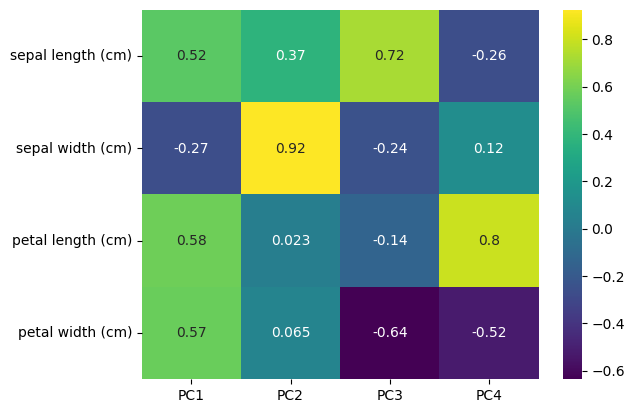

In [12]:
import pandas as pd
def components(bayesian_results, feature_names):
    """Plots the final Bayesian component matrix as a heatmap."""
    bayesian_comps = bayesian_results['components']
    pc_names = [f'PC{i+1}' for i in range(bayesian_comps.shape[1])]
    df_bayesian = pd.DataFrame(bayesian_comps, index=feature_names, columns=pc_names)
    # --- Visual Comparison: Heatmaps ---
    sns.heatmap(df_bayesian, annot=True, cmap='viridis')

components(bayesian_results, feature_names)

<Axes: >

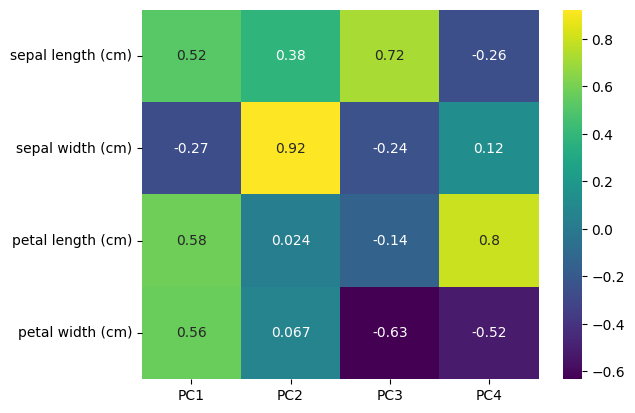

In [13]:
sklearn_comps = pca.components_.T
pc_names = [f'PC{i+1}' for i in range(sklearn_comps.shape[1])]
df_sklearn = pd.DataFrame(sklearn_comps, index=feature_names, columns=pc_names)
sns.heatmap(df_sklearn, annot=True, cmap='viridis')

##  Plots

In [14]:
def extract_results_for_plot(bayesian_results,X):
    # --- Extract Bayesian PCA results ---
    components = bayesian_results['components']
    explained_variance_ratio = bayesian_results['explained_variance_ratio']
    cumulative_variance = jnp.cumsum(explained_variance_ratio)
    num_components = components.shape[1]
    # --- Project data onto the principal components for the score plot ---
    X_projected = X @ components

    component_indices = jnp.arange(1, num_components + 1)

    return components, explained_variance_ratio, cumulative_variance, X_projected, component_indices

###  Cumulative_variance

/tmp/ipykernel_80860/1127060243.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  line, = ax.plot(


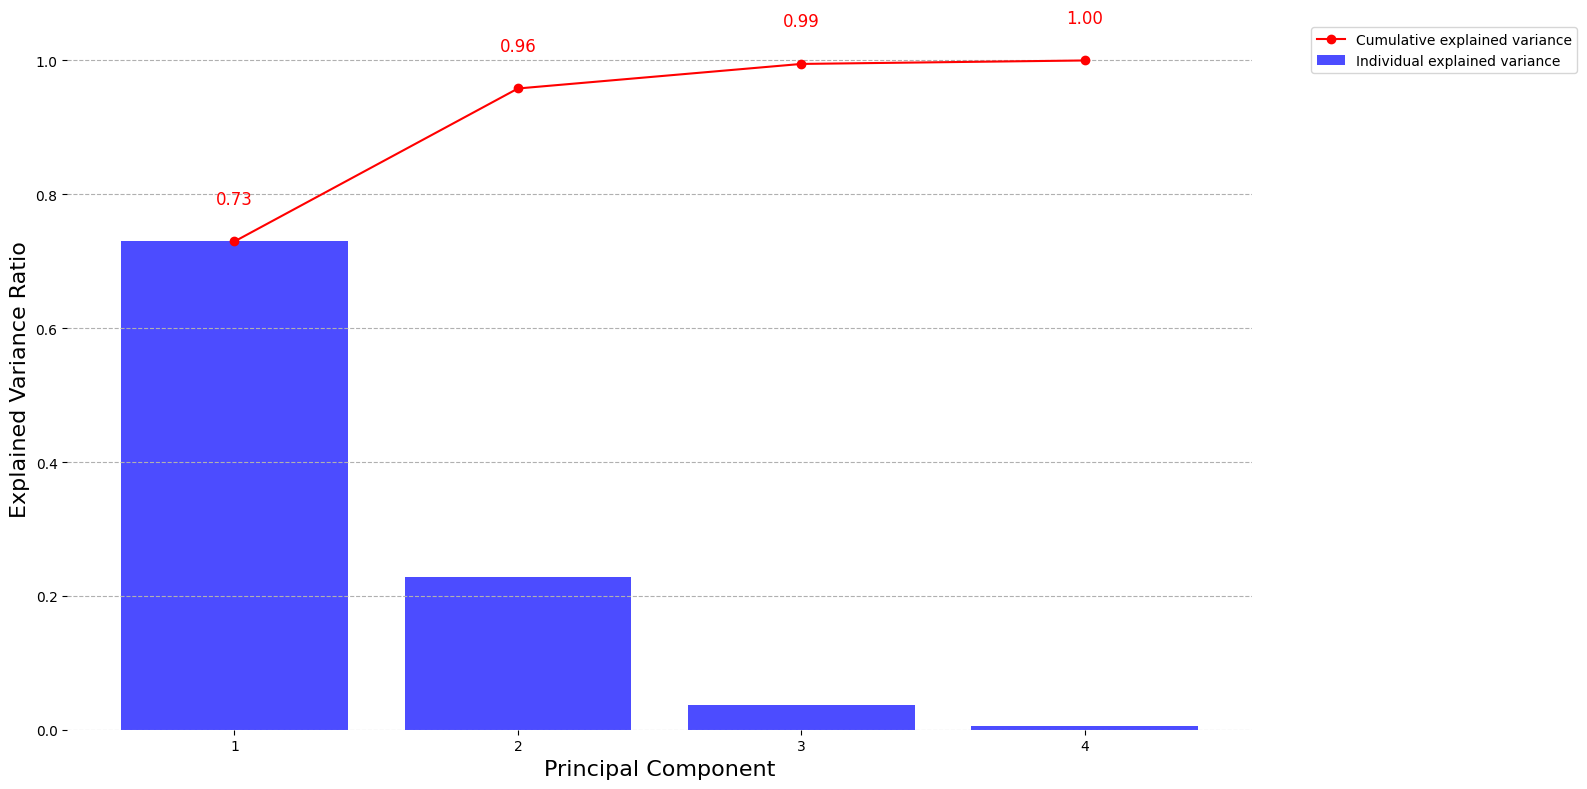

In [15]:
def cumulative_variance(
    X,
    bayesian_results,
    figsize=(16, 8),
    alpha=0.7,
    fontsize=10,
    color_bar='blue',
    color_cumulative_line='red',
    label_size=16,
    ):
    
    """Plots the cumulative explained variance for Bayesian PCA.
    Generates a scree plot with cumulative explained variance. 
    Args:
        X: The scaled data matrix of shape (num_datapoints, data_dim).
        bayesian_results: Dictionary containing 'explained_variance_ratio' and 'components'.    
        figsize: Tuple specifying the figure size.
        alpha: Transparency level for the bars.
        fontsize: Font size for annotations.
        color_bar: Color for the bars.
        color_cumulative_line: Color for the cumulative variance line.
        label_size: Font size for axis labels.
    Returns:
        None (displays the plot)
    """
    # --- Extract Bayesian PCA results ---
    components, explained_variance_ratio, cumulative_variance, X_projected, component_indices = extract_results_for_plot(bayesian_results, X)

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)

    # Plot bars and cumulative line
    ax.bar(
        component_indices,
        explained_variance_ratio,
        alpha=alpha,
        color=color_bar,
        align='center',
        label='Individual explained variance'
    )

    # Plot cumulative explained variance with red dots
    line, = ax.plot(
        component_indices,
        cumulative_variance,
        'ro-',
        color=color_cumulative_line,
        label='Cumulative explained variance'
    )

    # Add annotations for each red dot
    for i, (x, y) in enumerate(zip(component_indices, cumulative_variance)):
        ax.annotate(
            f'{y:.2f}',  # Format the cumulative variance to 2 decimal places
            xy=(x, y),   # Coordinates of the red dot
            xytext=(x, y + 0.05),  # Position of the annotation text (slightly above the dot)
            ha='center',  # Horizontal alignment
            va='bottom',  # Vertical alignment
            fontsize=fontsize,  # Font size
            color=color_cumulative_line,  # Text color
        )

    # Set labels and ticks
    ax.set_xticks(component_indices)
    ax.set_xlabel('Principal Component', fontsize=label_size)
    ax.set_ylabel('Explained Variance Ratio', fontsize=label_size)


    # Place legend outside the plot
    ax.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.
    )

    # Remove vertical grid lines
    ax.grid(axis='x', linestyle='')
    ax.grid(axis='y', linestyle='--')

    # Remove all spines (lines around the plot)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Adjust layout to prevent legend from being cut off
    plt.tight_layout()
    plt.show()

cumulative_variance(X_scaled,bayesian_results,fontsize=12)

### Projection

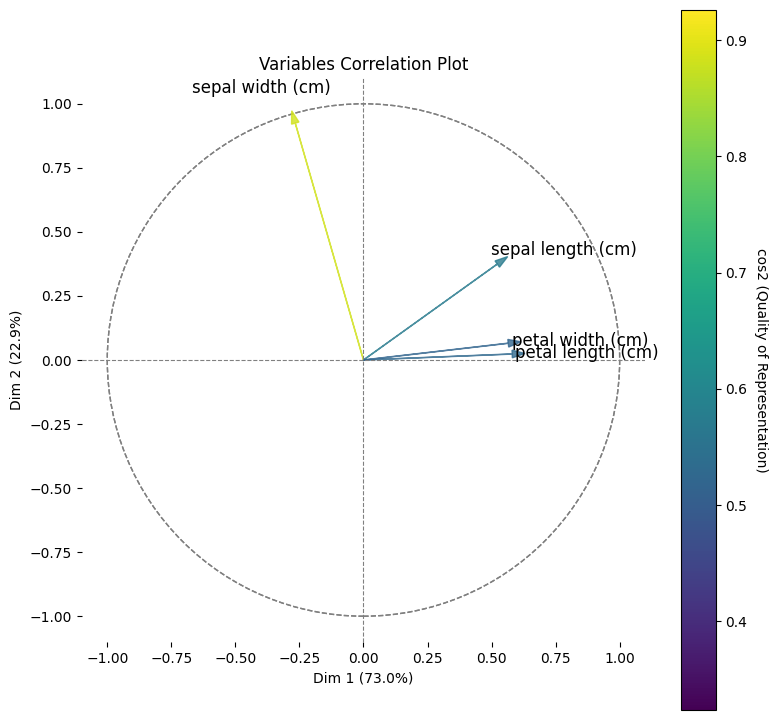

In [18]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a confidence ellipse for a set of x, y points.
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = jnp.cov(x, y)
    pearson = cov[0, 1] / jnp.sqrt(cov[0, 0] * cov[1, 1])
    
    ell_radius_x = jnp.sqrt(1 + pearson)
    ell_radius_y = jnp.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    scale_x = jnp.sqrt(cov[0, 0]) * n_std
    mean_x = jnp.mean(x)

    scale_y = jnp.sqrt(cov[1, 1]) * n_std
    mean_y = jnp.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def variable_correlation(X_scaled, bayesian_results, feature_names):
    """
    Generates a variable correlation plot with cos2 values for Bayesian PCA results.
    Args:
        X_scaled: The scaled data matrix of shape (num_datapoints, data_dim).
        bayesian_results: Dictionary containing 'components' and 'explained_variance_ratio'.
        feature_names: List of names for the original features.
    Returns:
        None (displays the plot)
    """
    # --- Extract Bayesian PCA results ---
    components, explained_variance_ratio, cumulative_variance, X_projected, component_indices = extract_results_for_plot    (bayesian_results, X_scaled)

    # Variable contributions (loadings)
    loadings = components

    # Cos2 for variables (quality of representation)
    var_cos2 = loadings**2
    var_cos2_pc1_pc2 = jnp.sum(var_cos2[:, :2], axis=1)
    # Cos2 for individuals
    dist_sq_origin = jnp.sum(X_scaled**2, axis=1)
    ind_cos2 = X_projected**2
    ind_cos2 = ind_cos2 / dist_sq_origin[:, None]
    ind_cos2_pc1_pc2 = jnp.sum(ind_cos2[:, :2], axis=1)

    fig = plt.figure(figsize=(20, 20))


    # 1. Variable Correlation Plot (with cos2)
    ax1 = fig.add_subplot(2, 2, 1, aspect='equal')
    ax1.set_xlim(-1.1, 1.1)
    ax1.set_ylim(-1.1, 1.1)

    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
    ax1.add_artist(circle)

    # Draw circle
    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
    ax1.add_artist(circle)

    # Draw arrows colored by cos2
    for i in range(len(feature_names)):
        scatter = ax1.arrow(0, 0, loadings[i, 0], loadings[i, 1],
                            head_width=0.03, head_length=0.05,
                            color=plt.cm.viridis(var_cos2_pc1_pc2[i]),
                            alpha=0.8)

        ax1.text(loadings[i, 0] * 1.5, loadings[i, 1] * 1.15, feature_names[i],ha='center', va='center', fontsize=12)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(var_cos2_pc1_pc2), vmax=max(var_cos2_pc1_pc2)))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax1)
    cbar.set_label('cos2 (Quality of Representation)', rotation=270, labelpad=15)

    ax1.set_xlabel(f'Dim 1 ({explained_variance_ratio[0]:.1%})')
    ax1.set_ylabel(f'Dim 2 ({explained_variance_ratio[1]:.1%})')
    ax1.set_title('Variables Correlation Plot')
    ax1.axhline(0, linestyle='--', color='grey', linewidth=0.8)
    ax1.axvline(0, linestyle='--', color='grey', linewidth=0.8)

    ax1.grid(axis='x', linestyle='')
    ax1.grid(axis='y', linestyle='')

    # Remove all spines (lines around the plot)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    plt.show()

variable_correlation(X_scaled, bayesian_results, feature_names)

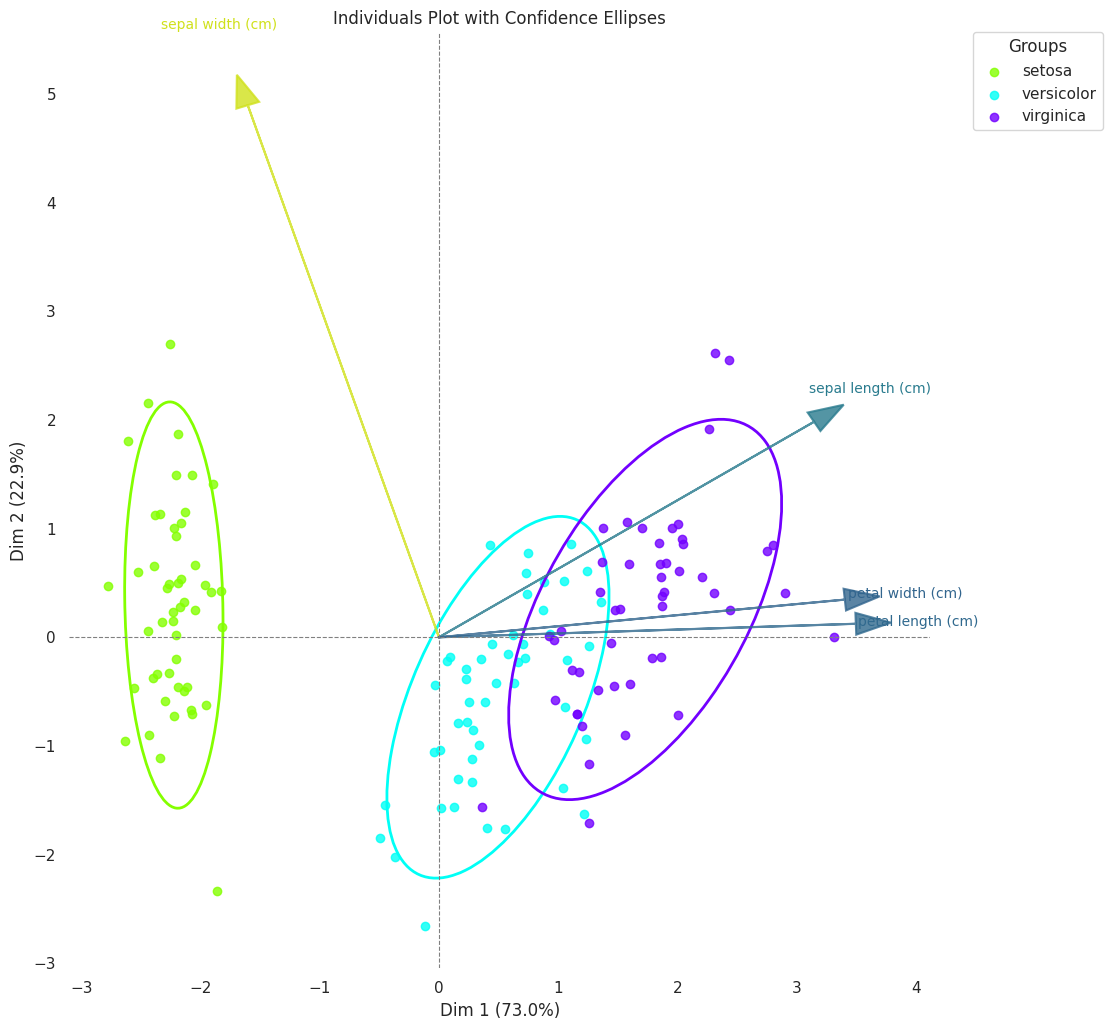

In [ ]:
from matplotlib.patches import Ellipse, Arrow
import matplotlib.transforms as transforms
import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp

def variable_correlation(X_scaled, bayesian_results, y=None, feature_names=None, target_names=None,
                         color_var=None, size_var=None, shape_var=None):
    """
    Generates a variable correlation plot with cos2 values for Bayesian PCA results.
    """
    # --- Extract Bayesian PCA results ---
    components, explained_variance_ratio, cumulative_variance, X_projected, component_indices = extract_results_for_plot(bayesian_results, X_scaled)
    loadings = components  # Assign loadings from components
    # Calculate cos2 for variables
    var_cos2 = loadings**2
    var_cos2_pc1_pc2 = jnp.sum(var_cos2[:, :2], axis=1)

    # --- Individuals Plot with Grouping and Ellipses ---
    fig = plt.figure(figsize=(20, 20))
    ax2 = fig.add_subplot(2, 2, 2)

    # Plot the projected data points first
    if y is not None and target_names is not None:
        palette = sns.color_palette("hsv", len(target_names))
        for i, target_name in enumerate(target_names):
            indices = jnp.where(y == i)[0]
            ax2.scatter(
                X_projected[indices, 0],
                X_projected[indices, 1],
                label=target_name,
                color=palette[i],
                alpha=0.8
            )
            confidence_ellipse(
                X_projected[indices, 0],
                X_projected[indices, 1],
                ax2,
                edgecolor=palette[i],
                linewidth=2
            )

    # Plot with continuous color, size, and shape
    if shape_var is not None:
        unique_shapes = jnp.unique(shape_var)
        unique_shapes = [int(shape) if jnp.issubdtype(shape.dtype, jnp.integer) else float(shape)
                         for shape in unique_shapes]
        markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', 'd']
        marker_dict = {shape: markers[i % len(markers)] for i, shape in enumerate(unique_shapes)}

    if color_var is not None and size_var is not None and shape_var is not None:
        if isinstance(size_var, (jnp.ndarray, list)):
            size_var = 100 * (jnp.array(size_var) - min(size_var)) / (max(size_var) - min(size_var)) + 10
        for shape in unique_shapes:
            indices = jnp.where(shape_var == shape)[0]
            ax2.scatter(
                X_projected[indices, 0],
                X_projected[indices, 1],
                c=color_var[indices],
                s=size_var[indices],
                cmap='viridis',
                marker=marker_dict[shape],
                alpha=0.8,
                label=f'Shape: {shape}'
            )
        scatter = plt.cm.ScalarMappable(cmap='viridis')
        scatter.set_array(color_var)
        plt.colorbar(scatter, ax=ax2, label='Color Variable')
        # Place legend outside the plot
        ax2.legend(
            title='Shapes',
            bbox_to_anchor=(1.05, 1),  # Position the legend outside the plot
            loc='upper left',           # Location of the legend
            borderaxespad=0.            # Padding between the axes and legend
        )

    elif color_var is not None and shape_var is not None:
        for shape in unique_shapes:
            indices = jnp.where(shape_var == shape)[0]
            ax2.scatter(
                X_projected[indices, 0],
                X_projected[indices, 1],
                c=color_var[indices],
                cmap='viridis',
                marker=marker_dict[shape],
                alpha=0.8,
                label=f'Shape: {shape}'
            )
        scatter = plt.cm.ScalarMappable(cmap='viridis')
        scatter.set_array(color_var)
        plt.colorbar(scatter, ax=ax2, label='Color Variable')
        # Place legend outside the plot
        ax2.legend(
            title='Shapes',
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0.
        )

    elif size_var is not None and shape_var is not None:
        if isinstance(size_var, (jnp.ndarray, list)):
            size_var = 100 * (jnp.array(size_var) - min(size_var)) / (max(size_var) - min(size_var)) + 10
        for shape in unique_shapes:
            indices = jnp.where(shape_var == shape)[0]
            ax2.scatter(
                X_projected[indices, 0],
                X_projected[indices, 1],
                s=size_var[indices],
                marker=marker_dict[shape],
                alpha=0.8,
                label=f'Shape: {shape}'
            )
        # Place legend outside the plot
        ax2.legend(
            title='Shapes',
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0.
        )

    elif color_var is not None:
        scatter = ax2.scatter(
            X_projected[:, 0],
            X_projected[:, 1],
            c=color_var,
            cmap='viridis',
            alpha=0.8
        )
        plt.colorbar(scatter, ax=ax2, label='Color Variable')

    elif size_var is not None:
        if isinstance(size_var, (jnp.ndarray, list)):
            size_var = 100 * (jnp.array(size_var) - min(size_var)) / (max(size_var) - min(size_var)) + 10
        ax2.scatter(
            X_projected[:, 0],
            X_projected[:, 1],
            s=size_var,
            alpha=0.8
        )

    elif shape_var is not None:
        for shape in unique_shapes:
            indices = jnp.where(shape_var == shape)[0]
            ax2.scatter(
                X_projected[indices, 0],
                X_projected[indices, 1],
                marker=marker_dict[shape],
                alpha=0.8,
                label=f'Shape: {shape}'
            )
        # Place legend outside the plot
        ax2.legend(
            title='Shapes',
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0.
        )

    elif y is not None and target_names is not None:
        # Place legend outside the plot
        ax2.legend(
            title='Groups',
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0.
        )

    else:
        ax2.scatter(X_projected[:, 0], X_projected[:, 1], alpha=0.7)

    ax2.set_xlabel(f'Dim 1 ({explained_variance_ratio[0]:.1%})')
    ax2.set_ylabel(f'Dim 2 ({explained_variance_ratio[1]:.1%})')
    ax2.set_title('Individuals Plot with Confidence Ellipses')
    ax2.axhline(0, linestyle='--', color='grey', linewidth=0.8)
    ax2.axvline(0, linestyle='--', color='grey', linewidth=0.8)
    ax2.grid(axis='x', linestyle='')
    ax2.grid(axis='y', linestyle='')

    # Add arrows for features, scaled based on x and y limits
    if feature_names is not None:
        x_lim = ax2.get_xlim()
        y_lim = ax2.get_ylim()
        x_range = x_lim[1] - x_lim[0]
        y_range = y_lim[1] - y_lim[0]
        scale_factor = 0.9
        for i, feature in enumerate(feature_names):
            scaled_x = loadings[i, 0] * scale_factor * x_range
            scaled_y = loadings[i, 1] * scale_factor * y_range
            ax2.arrow(
                0, 0,
                scaled_x, scaled_y,
                head_width=0.03 * x_range,
                head_length=0.05 * y_range,
                color=plt.cm.viridis(var_cos2_pc1_pc2[i]),
                alpha=0.8,
                linewidth=1.5
            )
            ax2.text(
                scaled_x * 1.15,
                scaled_y * 1.15,
                feature,
                color=plt.cm.viridis(var_cos2_pc1_pc2[i]),
                ha='center',
                va='center',
                fontsize=10
            )

    # Remove all spines (lines around the plot)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)

    # Adjust layout to prevent legend from being cut off
    plt.tight_layout()
    plt.show()

    return ax2

ax2= variable_correlation(
    X_scaled, 
    bayesian_results,  
    feature_names=feature_names,
    y=y,
    target_names=target_names
)

# References
https://www.tensorflow.org/probability/examples/Probabilistic_PCA

<a name='1'></a>[1]: Michael E. Tipping and Christopher M. Bishop. Probabilistic principal component analysis. Journal of the Royal Statistical Society: Series B (Statistical Methodology), 61(3): 611-622, 1999.